In [856]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib

calendar = pd.read_csv('./calendar.csv')
listings = pd.read_csv('./listings.csv')
reviews = pd.read_csv('./reviews.csv')

pd.set_option('display.max_columns', None)

# What contributes to getting a good score? 
# What does this imply about tourists visiting Seattle and each neighborhood? What about the future of travelling? 
# WHow can I be a better host? 


In [836]:
# clean data 

# Get rid of dollar signs
listings['price'] =listings['price'].replace('[\$,]', '', regex=True).astype(float)
listings['weekly_price'] = listings['weekly_price'].replace('[\$,]', '', regex=True).astype(float)
listings['monthly_price'] = listings['monthly_price'].replace('[\$,]', '', regex=True).astype(float)
listings['security_deposit'] = listings['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
listings['cleaning_fee'] = listings['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
listings['extra_people'] = listings['extra_people'].replace('[\$,]', '', regex=True).astype(float)



# Remove % sign
listings['host_response_rate'] = listings['host_response_rate'].str.rstrip('%').astype('float')/100
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.rstrip('%').astype('float')/100

# Changing booleans 
listings['host_is_superhost'] = listings.replace({'host_is_superhost': {'t': 1, 'f': 0}})
listings['host_has_profile_pic'] = listings.replace({'host_has_profile_pic': {'t': 1, 'f': 0}})
listings['host_identity_verified'] = listings.replace({'host_identity_verified': {'t': 1, 'f': 0}})
listings['is_location_exact'] = listings.replace({'is_location_exact': {'t': 1, 'f': 0}})
listings['has_availability'] = listings.replace({'has_availability': {'t': 1, 'f': 0}})


# Add new columns - how many months host has been a host
listings['nb_months'] = ((pd.to_datetime(listings.last_scraped)-pd.to_datetime(listings.host_since))/np.timedelta64(1, 'M'))




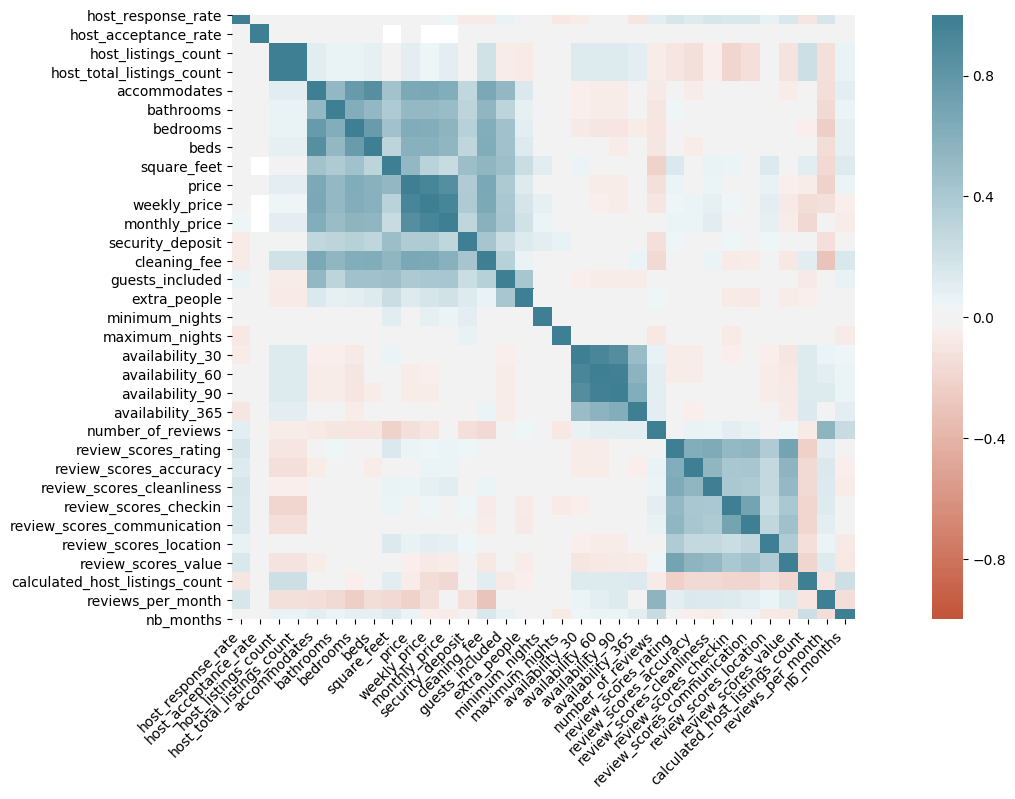

In [837]:
numerical_cols = listings.select_dtypes(exclude=['object']).drop(['id','scrape_id', 'host_id', 'license', 'latitude', 'longitude'], axis = 1)

#  
corr = numerical_cols.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 

In [838]:
A=numerical_cols.corr().unstack().sort_values(ascending=False)
print('The correlation of the review_scores_rating against all:', A['review_scores_rating'][1:-1])


The correlation of the review_scores_rating against all: review_scores_value            0.696534
review_scores_cleanliness      0.642882
review_scores_accuracy         0.621257
review_scores_communication    0.540620
review_scores_checkin          0.521813
review_scores_location         0.368423
host_response_rate             0.156567
square_feet                    0.143793
reviews_per_month              0.087313
price                          0.055551
monthly_price                  0.048595
weekly_price                   0.045262
bathrooms                      0.045101
security_deposit               0.044818
number_of_reviews              0.036242
bedrooms                       0.023257
minimum_nights                 0.001392
beds                          -0.000720
guests_included               -0.001430
cleaning_fee                  -0.004991
accommodates                  -0.013101
host_acceptance_rate          -0.016218
maximum_nights                -0.031313
nb_months              

In [839]:
# Build model on parameters with high correlation 
numerical_cols = numerical_cols.dropna(subset = ['review_scores_rating'], how = "any")
X = numerical_cols[['review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_communication', 'review_scores_checkin', 'review_scores_location', 'host_response_rate']]
X = X.fillna(X.mean(axis = 0))
y = numerical_cols[['review_scores_rating']]


In [840]:
# Linear Regression Model
X_Train,X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.3, random_state = 561)

mod = LinearRegression(normalize = True)
mod.fit(X_Train, y_Train)

    #Predict using your model
y_test_preds = mod.predict(X_Test)
y_train_preds = mod.predict(X_Train)

    #Score using your model
test_score = r2_score(y_Test, y_test_preds)
train_score = r2_score(y_Train, y_train_preds)

#Rsquared and y_test
rsquared_score = mod.score(X_Test, y_Test) #r2_score
length_y_test = len(y_Test) #num in y_test

#rsquared_score
print(test_score)
#print(train_score) 

# Uses columns with top six correlation coefficients to predict 

0.6625770012531501


In [841]:
# Build individual linear regression fopr review_scores_rating against each parameter 
y = numerical_cols[['review_scores_rating']]

test_scores = []
cols = []
# Show train and test scores for all variables against review_scores_rating
for col in numerical_cols.columns:
    X = numerical_cols[[col]]
    X = X.fillna(X.mean(axis = 0))
    
    X_Train,X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    mod = LinearRegression(normalize = True)
    mod.fit(X_Train, y_Train)

    #Predict using your model
    y_test_preds = mod.predict(X_Test)
    y_train_preds = mod.predict(X_Train)

        #Score using your model
    test_score = round(r2_score(y_Test, y_test_preds),3)
    train_score = r2_score(y_Train, y_train_preds)

    #Rsquared and y_test
    rsquared_score = mod.score(X_Test, y_Test) #r2_score
    length_y_test = len(y_Test) #num in y_test
    #print('test score for ', col, test_score)
    pd.DataFrame(cols.append(col))
    pd.DataFrame(test_scores.append(test_score))
    

In [842]:
review_scores_rating_Test_Scores = pd.concat([pd.DataFrame(cols), pd.DataFrame(test_scores)], axis = 1)
review_scores_rating_Test_Scores.columns = ['Variable', 'Score']
review_scores_rating_Test_Scores = review_scores_rating_Test_Scores.sort_values(by=['Score'], ascending = False)
review_scores_rating_Test_Scores

,Variable,Score
23,review_scores_rating,1.000
29,review_scores_value,0.477
24,review_scores_accuracy,0.428
27,review_scores_communication,0.390
25,review_scores_cleanliness,0.384
26,review_scores_checkin,0.339
28,review_scores_location,0.169
30,calculated_host_listings_count,0.038
0,host_response_rate,0.027
31,reviews_per_month,0.007


In [843]:
# Build model against top six, but add one each time - these are invalid models, still 60% is the best
#numerical_cols = numerical_cols.dropna(subset = ['review_scores_rating'], how = "any")
#X = numerical_cols[['review_scores_accuracy', 'review_scores_value']]
#X = X.fillna(X.mean(axis = 0))
#y = numerical_cols[['review_scores_rating']]

In [845]:
#numerical_cols = numerical_cols.dropna(subset = ['review_scores_rating'], how = "any")

numerical_cols = numerical_cols.dropna(subset = ['review_scores_rating'], how = "any")
y = numerical_cols[['review_scores_rating']]
X = []
X_Score = []
for col in range(1,len(review_scores_rating_Test_Scores)):
    numerical_cols = numerical_cols.dropna(subset = ['review_scores_rating'], how = "any")
    y = numerical_cols[['review_scores_rating']]
    X.append(review_scores_rating_Test_Scores.Variable[col])
    df_X = numerical_cols[X]
    df_X = df_X.fillna(df_X.mean(axis = 0))
    #print(df_X)
    
    X_Train,X_Test, y_Train, y_Test = train_test_split(df_X, y, test_size = 0.3, random_state = 42)

    mod = LinearRegression(normalize = True)
    mod.fit(X_Train, y_Train)

    #Predict using your model
    y_test_preds = mod.predict(X_Test)
    y_train_preds = mod.predict(X_Train)

    #Score using your model
    test_score = round(r2_score(y_Test, y_test_preds),3)
    train_score = r2_score(y_Train, y_train_preds)

    #Rsquared and y_test
    rsquared_score = mod.score(X_Test, y_Test) #r2_score
    length_y_test = len(y_Test) #num in y_test
    #print('test score for ', col, test_score)
    pd.DataFrame(cols.append(col))
    pd.DataFrame(test_scores.append(test_score))    
    print(df_X.columns)
    print(test_score)
    
    #X_df = pd.concat([pd.DataFrame(X), pd.DataFrame(X_Score)], axis = 1)
    #print(X_df)
#X = numerical_cols[['review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_communication', 'review_scores_checkin', 'review_scores_location', 'host_response_rate']]
    #X_df = X_df.fillna(X_df.mean(axis = 0))
    #print(X_df)
#numerical_cols[X]

Index(['host_acceptance_rate'], dtype='object')
-43.173
Index(['host_acceptance_rate', 'host_listings_count'], dtype='object')
-85.799
Index(['host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count'],
      dtype='object')
-85.799
Index(['host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'accommodates'],
      dtype='object')
-95.701
Index(['host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'accommodates', 'bathrooms'],
      dtype='object')
-117.105
Index(['host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms'],
      dtype='object')
-130.95
Index(['host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'beds'],
      dtype='object')
-131.726
Index(['host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'accommodates', 'bathrooms

Index(['host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'square_feet', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'nb_months'],
      dtype='object')
1.0


In [888]:
# Build model with categorical variables 
df = listings
df = df.dropna(subset=['review_scores_rating'], how = "any")
all_categories = df.select_dtypes(include = ['object']) #dataframe of all the categorical vars 
categories = all_categories.select_dtypes(include=['object']).drop(list(all_categories.columns[(all_categories.nunique()) == 3818] | all_categories.columns[(all_categories.nunique()) == 1]), axis = 1)
url_cols = []
for col in categories.columns:
    if 'url' in col:
        url_cols.append(col)
    else:
        ""

categories = categories.drop(list(url_cols), axis = 1) # categories of interest 
get_dummies = pd.get_dummies(categories, dummy_na = False, drop_first=True) # all the dummy variables 

df = df.drop(all_categories, axis = 1)
df = df.fillna(df.mean(axis = 0))
df = df.dropna(how = 'all', axis = 1)

merged_df = pd.concat([df, get_dummies], axis = 1)

X = merged_df.loc[:, merged_df.columns != 'review_scores_rating']
y = merged_df[['review_scores_rating']]  
#merged_df = merged_df.apply(lambda x: x.fillna(x.mean()),axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=102)
lm_model = LinearRegression(normalize=True) # Instantiate

lm_model.fit(X_train, y_train) #Fit


#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
print(test_score)


0.3128058095281405


In [859]:
numerical_cols = listings.select_dtypes(exclude=['object']).drop(['id','scrape_id', 'host_id', 'license', 'latitude', 'longitude'], axis = 1)
# Normalize two columns, review_scores_rating and reviews_per_month
cols_to_norm = ['review_scores_rating','reviews_per_month']
numerical_cols[cols_to_norm] = numerical_cols[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

numerical_cols['norm_columns'] = listings[cols_to_norm].mean(axis = 1)



In [883]:
new_listings = numerical_cols.dropna(subset = ['norm_columns'], how = "any")
new_listings.head(5)

,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,norm_columns
0,3.0,3.0,4,1.0,1.0,1.0,NaN,2,1,365,14,41,71,346,207,0.9375,10.0,10.0,10.0,10.0,9.0,10.0,2,0.333883,49.535
1,6.0,6.0,4,1.0,1.0,1.0,NaN,1,2,90,13,13,16,291,43,0.9500,10.0,10.0,10.0,10.0,10.0,10.0,6,0.120363,48.740
2,2.0,2.0,11,4.5,5.0,7.0,NaN,10,4,30,1,6,17,220,20,0.9625,10.0,10.0,10.0,10.0,10.0,10.0,2,0.093157,49.075
4,2.0,2.0,6,2.0,3.0,3.0,NaN,6,1,1125,30,60,90,365,38,0.9000,9.0,9.0,10.0,10.0,9.0,9.0,1,0.071723,46.445
5,1.0,1.0,2,1.0,1.0,1.0,NaN,1,1,6,0,0,27,302,17,0.9375,10.0,10.0,10.0,10.0,10.0,10.0,1,0.200330,48.725


In [886]:
# Create linear regression on normalized score

new_listings = numerical_cols.dropna(subset = ['norm_columns'], how = "any")
#X = numerical_cols.loc[:,numerical_cols.columns != 'review_scores_rating']
X = new_listings[['review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_communication', 'review_scores_checkin', 'review_scores_location']]
X = X.fillna(X.mean(axis = 0))
y = new_listings[['norm_columns']]

# Linear Regression Model
X_Train,X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.3, random_state = 100)

mod = LinearRegression(normalize = True)
mod.fit(X_Train, y_Train)

    #Predict using your model
y_test_preds = mod.predict(X_Test)
y_train_preds = mod.predict(X_Train)

    #Score using your model
test_score = r2_score(y_Test, y_test_preds)
train_score = r2_score(y_Train, y_train_preds)

#Rsquared and y_test
rsquared_score = mod.score(X_Test, y_Test) #r2_score
length_y_test = len(y_Test) #num in y_test

#rsquared_score
print(test_score)
#print(train_score) 

# Best we could get was around 60%
# Is there a way to 

0.27291333553392294


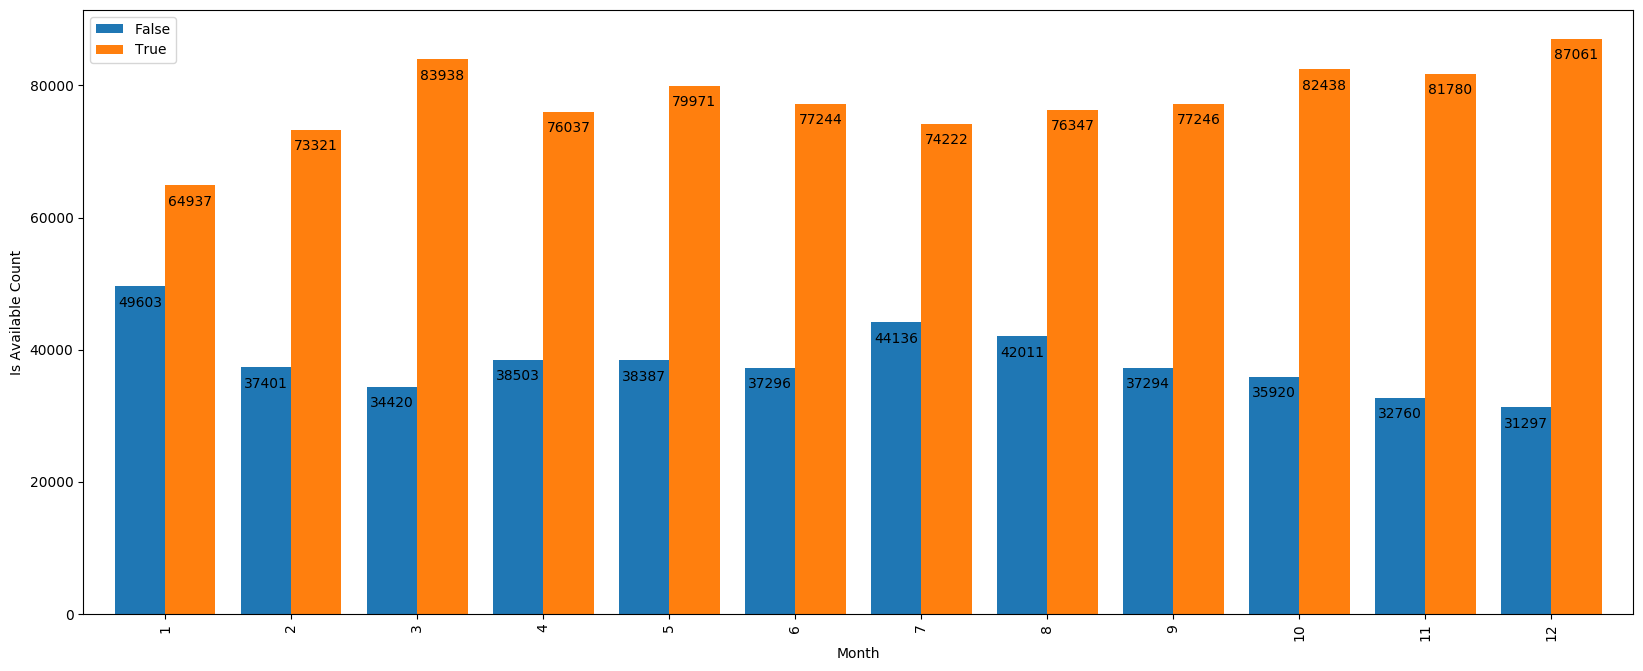

In [891]:
# convert date column to date time 
calendar['date']= pd.to_datetime(calendar['date'])

# adding in columns for day, month, year
calendar['year'] = pd.DatetimeIndex(calendar['date']).year
calendar['month'] = pd.DatetimeIndex(calendar['date']).month
calendar['day'] = pd.DatetimeIndex(calendar['date']).day

available_by_month = calendar.groupby(['month', 'available']).size().reset_index()

availability_plot = calendar.groupby('available').month.value_counts().unstack(0).plot(kind = 'bar', width = 0.8)
plt.xlabel("Month")
plt.ylabel("Is Available Count")
plt.legend(["False", "True"])
    
for p in availability_plot.patches:
    availability_plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

In [1017]:
#available_by_month.groupby(['month', 'available']).sum()
total_listings_per_month = available_by_month.groupby('month').sum()
total_listings_per_month = total_listings_per_month.reset_index(drop = True)

# Get percentage of when it is available 
is_available = pd.DataFrame((available_by_month[available_by_month.available=='t'])[0])#pd.DataFrame(available_by_month[available_by_month.available=='t'].iloc[:,2])
is_available = is_available.reset_index(drop = True)




#pd.DataFrame(is_available)/pd.DataFrame(total_listings_per_month)
#is_available_percentage = is_available_percentage.dropna(how = 'any', axis = 0)


In [1021]:
is_available_df = pd.concat([total_listings_per_month, is_available], axis = 1)
is_available_df.columns = ['total', 'is_available']
is_available_df['%Available'] = is_available_df['is_available']/is_available_df['total']
is_available_df

,total,is_available,%Available
0,114540,64937,0.566937
1,110722,73321,0.662208
2,118358,83938,0.709187
3,114540,76037,0.663847
4,118358,79971,0.675670
5,114540,77244,0.674384
6,118358,74222,0.627097
7,118358,76347,0.645051
8,114540,77246,0.674402
9,118358,82438,0.696514


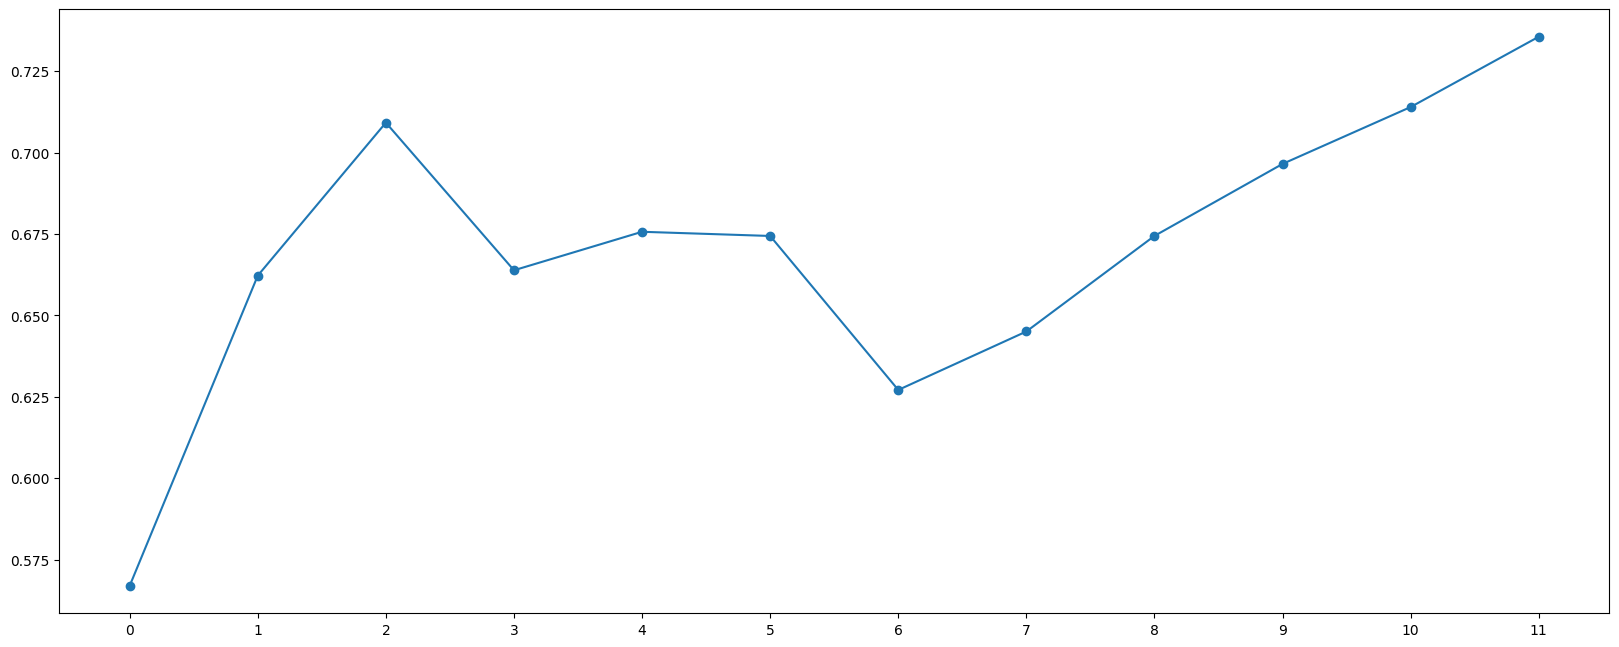

In [1030]:
#matplotlib.pyplot.scatter(is_available_df.index, is_available_df['%Available'])
plt.xticks(is_available_df.index);
plt.plot(is_available_df.index, is_available_df['%Available'], '-o')
plt.show()

In [ ]:
# which neighborhood has the highest rated listings
# which one has the most available throughout the year 